In [1]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, gamma, uniform, poisson, norm
from scipy.special import comb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import tqdm
from joblib import Parallel, delayed


# Generation of a c samples

In [2]:
cum_days = np.array([9, 21, 32, 36, 43, 45, 50, 58, 63, 70, 71, 77, 78, 87, 91, 92, 95, 98, 104, 105, 116, 149, 156, 247, 249, 250])
errors = np.arange(len(cum_days)) + 1

Estimated a: 0.2145262940954025, mutiplicative term: 0.2564439232162339
Estimated c: -0.16345729154005484, power term: 0.8365427084599452


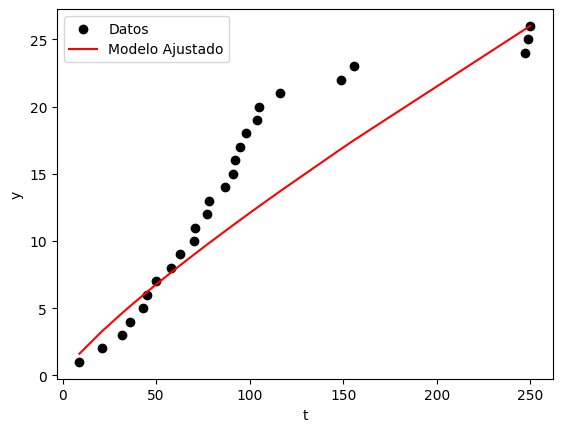

In [3]:
np.random.seed(123)

# Observation period
T = max(cum_days)
n = len(cum_days)

# Define the negative log-likelihood function
def neg_log_likelihood(params):
    a, c = params
    return a * (T**(c+1)) / (c+1) - n * np.log(a) - c * np.sum(np.log(cum_days))  

# Initial guess for parameters
initial_guess = [1.0, 1.0]

# Perform the optimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B')

# Extract the estimated parameters
a_est, c_est = result.x

print(f"Estimated a: {a_est}, mutiplicative term: {a_est/(c_est+1)}")
print(f"Estimated c: {c_est}, power term: {c_est+1}")

# Graficar los datos y el modelo ajustado para visualización
plt.scatter(cum_days, errors, label='Datos', color='black')
plt.plot(cum_days, a_est * cum_days ** (1 + c_est) / (1 + c_est), label='Modelo Ajustado', color='red')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_prima, c_prima]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 106 seconds.


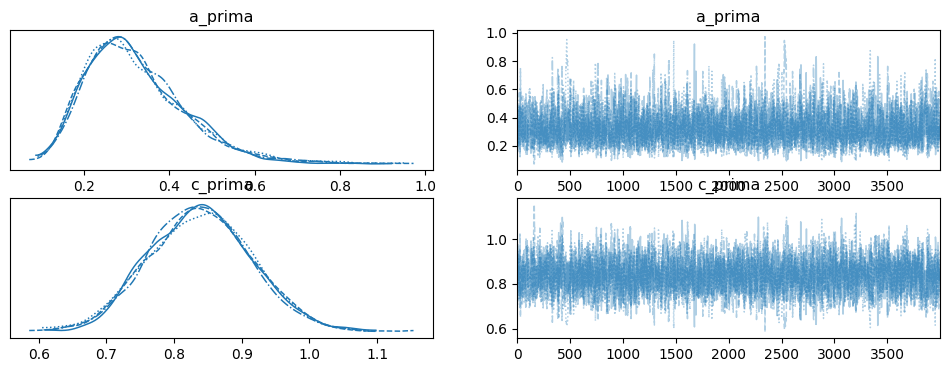

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_prima  0.32  0.12    0.12     0.54        0.0      0.0   2731.43   2928.32   
c_prima  0.84  0.08    0.69     0.98        0.0      0.0   2743.73   2952.25   

         r_hat  
a_prima    1.0  
c_prima    1.0  
Estimación de 'a': 0.322175181222614
Estimación de 'c': 0.8387423907525524


In [5]:
a_prima_est = a_est / (c_est + 1)
c_prima_est = c_est + 1
with pm.Model() as model:    
    a_prima = pm.Gamma('a_prima', alpha=10*a_prima_est**2, beta=10*a_prima_est) 
    c_prima = pm.Gamma('c_prima', alpha=10*c_prima_est**2, beta=10*c_prima_est)
    m_t = a_prima * cum_days ** c_prima

    # a = pm.Exponential('a', lam=a_est)  
    # c = pm.Normal('c', mu=c_est, sigma=0.1)  
    # m_t = a * cum_days ** (c+1)/(c+1)

    observed = pm.Poisson('observed', mu=m_t, observed=errors)
    
    trace = pm.sample(4000, tune=2000, target_accept=0.9, return_inferencedata=True)


# Analizar y visualizar los resultados del muestreo
az.plot_trace(trace)
plt.show()

# Resumen de la distribución posterior
summary = az.summary(trace, round_to=2)
print(summary)

# Extraer los valores medios de 'a' y 'c' de la distribución posterior
a_estimated = trace.posterior["a_prima"].mean().item()
c_estimated = trace.posterior["c_prima"].mean().item()

print("Estimación de 'a':", a_estimated)
print("Estimación de 'c':", c_estimated)

array([[<Axes: >, None],
       [<Axes: xlabel='a_prima', ylabel='c_prima'>, <Axes: >]],
      dtype=object)

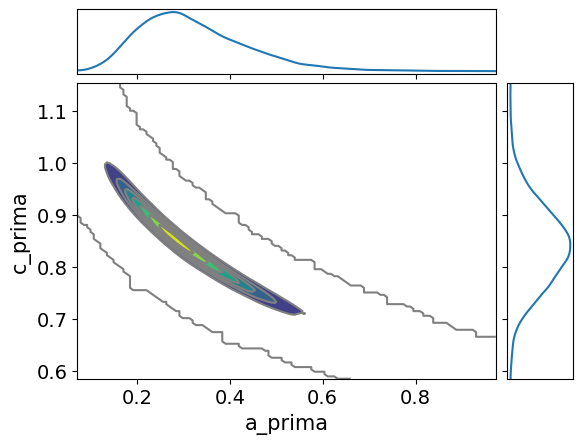

In [59]:
az.plot_pair(trace, divergences=True, kind='kde', marginals=True)

# Auxiliar functions

In [2]:
trace = az.from_netcdf('trace.nc')

In [3]:
def sample_random_ac(trace, num_pairs):
    n_samples = trace.posterior.sizes["draw"]  # Número de muestras
    n_chains = trace.posterior.sizes["chain"]  # Número de cadenas

    # Seleccionar aleatoriamente pares de valores
    random_indices = np.random.choice(n_samples * n_chains, num_pairs)  # Índices aleatorios

    chain_indices = random_indices // n_samples  # Índices de la cadena
    draw_indices = random_indices % n_samples  # Índices de la muestra dentro de la cadena

    # Extraer valores de la cadena posterior usando indexación avanzada
    a_values = trace.posterior["a_prima"].values[chain_indices, draw_indices]
    c_values = trace.posterior["c_prima"].values[chain_indices, draw_indices]

    # Combinar los valores a y c en pares
    random_ac = np.column_stack((a_values, c_values))
    return random_ac

In [4]:
def utility_func(x, rho1):
    if rho1 is None: 
        return x
    return (1 - np.exp(-rho1 * x)) / rho1

# Simple case

In [31]:
def compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=12000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = fact * (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])
    
    profit = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * (l * p1 - c1) for l in range(n+1)])
    
    return util, pi, profit

In [25]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((100 * 100, 4))
indice = 0
for p1 in np.linspace(3000, 15000, 100):
    for t1 in np.linspace(0, 2000, 100):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10151.51515152   929.29292929] Mejor utilidad: 3464304.466521217 Mejor probabilidad: 0.3413558245900615


In [26]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((50 * 50, 4)) 
indice = 0
for p1 in np.linspace(9500, 11000, 50):
    for t1 in np.linspace(500, 1000, 50):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados_resolucion.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10234.69387755   551.02040816] Mejor utilidad: 3485064.531083048 Mejor probabilidad: 0.34060415979139613


In [10]:
resultados = np.load('resultados.npy')

In [11]:
indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Mejores datos: [9303.03030303  545.45454545] Mejor utilidad: 2867361.236590402 Mejor probabilidad: 0.3183345430786342


In [16]:
mejores_precios = []
for i in range(50):
    seleccion = resultados[abs(resultados[:, 1] - np.linspace(0, 2000, 50)[i]) < 1e-1]    
    mejores_precios.append(seleccion[np.argmax(seleccion[:, 2]), 0])

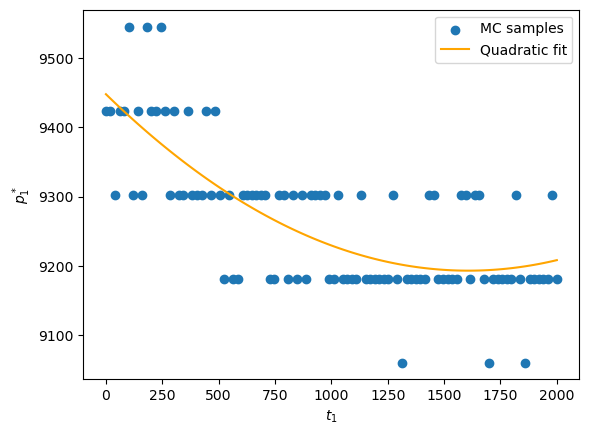

In [17]:
xs = np.linspace(0, 2000, 50)
c, b, a = np.polyfit(xs, mejores_precios, 2)
ys = a + b * xs + c * xs ** 2

plt.scatter(xs, mejores_precios)
plt.plot(xs, ys, color='orange')
plt.xlabel('$t_1$')
plt.ylabel('$p^*_1$')
plt.legend(['MC samples', 'Quadratic fit'])

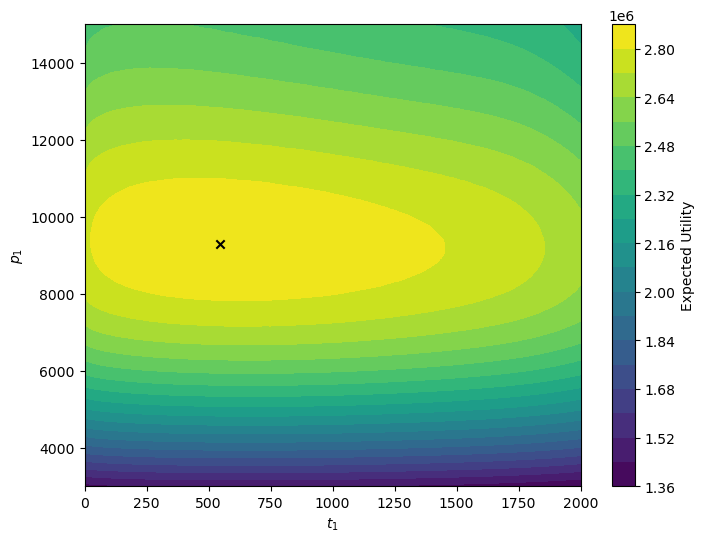

In [18]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

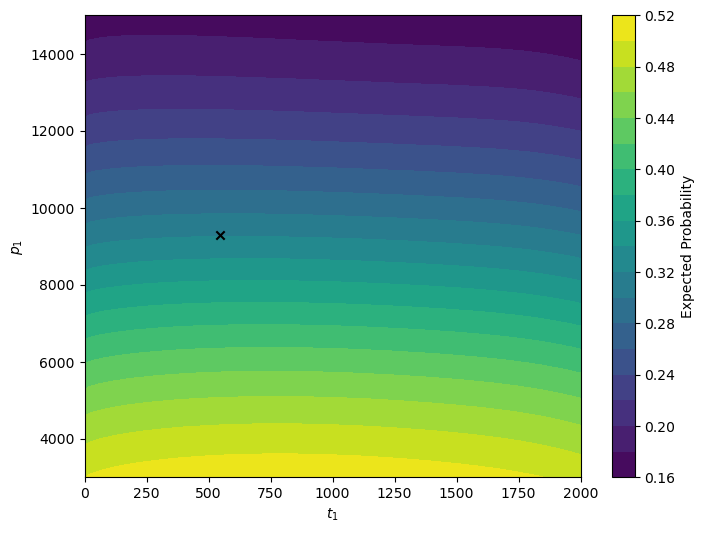

In [19]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

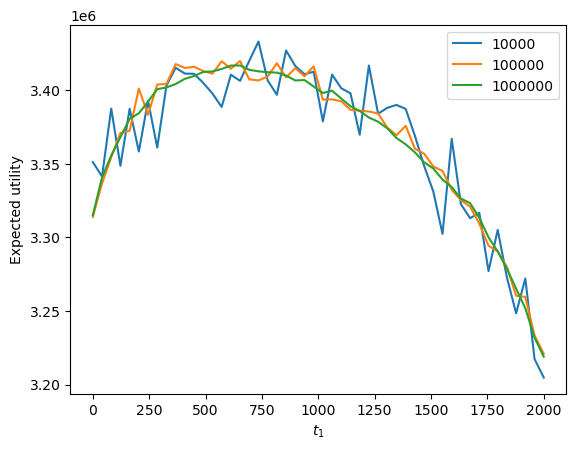

In [15]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 10151.51515152
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=1000000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([10000, 100000, 1000000])

In [20]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((7 * 20 * 20, 6)) 
indice = 0

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho1 in rhos:
    print(rho1)
    for p1 in np.linspace(9500, 12000, 20):
        for t1 in np.linspace(500, 1000, 20):
            util, prob, profit = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000, rho1=rho1)
            resultados[indice] = [p1, t1, util, prob, profit, rho1]
            indice += 1
np.save('resultados_rhos.npy', resultados)

-1e-06


NameError: name 'compute_expected_utility_vec_random_ac' is not defined

In [21]:
resultados_rho = np.load('resultados_rho.npy', allow_pickle=True)

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho in rhos:
    if rho is None:
        seleccion = resultados_rho[[r is None for r in resultados_rho[:, 5]]]   
    else:
        seleccion = resultados_rho[resultados_rho[:, 5] == rho]    
    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]
    mejor_profit = seleccion[indice_mejor, 4]

    print(f"Rho: {rho}, p_1: {mejor_datos[0]:.0f}, t_1: {mejor_datos[1]:.0f}, Expected utility: {mejor_util:.0f}, Profit: {mejor_profit:.0f}, Probability: {mejor_prob:.2f}")

Rho: -1e-06, p_1: 9408, t_1: 541, Expected utility: 16764121, Profit: 2867624, Probability: 0.31
Rho: -1e-07, p_1: 9286, t_1: 549, Expected utility: 3322790, Profit: 2867974, Probability: 0.32
Rho: -1e-08, p_1: 9286, t_1: 569, Expected utility: 2909383, Profit: 2867770, Probability: 0.32
Rho: None, p_1: 9286, t_1: 578, Expected utility: 2867904, Profit: 2867904, Probability: 0.32
Rho: 1e-08, p_1: 9327, t_1: 537, Expected utility: 2827129, Profit: 2867956, Probability: 0.32
Rho: 1e-07, p_1: 9327, t_1: 569, Expected utility: 2492472, Profit: 2867731, Probability: 0.32
Rho: 1e-06, p_1: 9163, t_1: 565, Expected utility: 942641, Profit: 2867599, Probability: 0.32


In [22]:
resultados_c31 = np.load('resultados_c31.npy', allow_pickle=True)

c31s = np.linspace(1, 40, 40)
df_resultados = pd.DataFrame(columns=['c31', 'p1', 't1', 'util', 'prob'])
for c31 in c31s:
    seleccion = resultados_c31[resultados_c31[:, 4] == c31]    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    new_row = pd.DataFrame([{'c31': c31, 'p1': mejor_datos[0], 't1': mejor_datos[1], 'util': mejor_util, 'prob': mejor_prob}])
    df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)

/tmp/ipykernel_3056859/516916922.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)


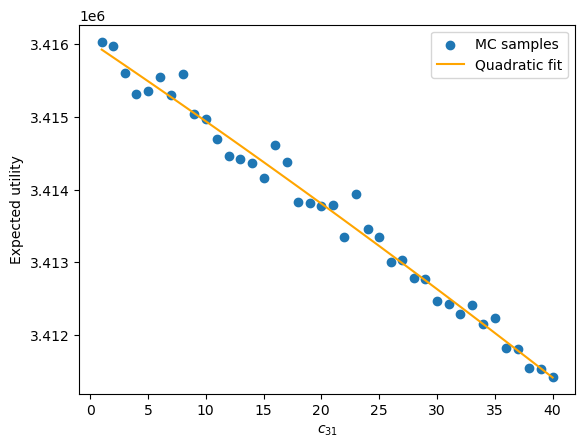

In [23]:
# plot of the expected utility as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['util'])
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['util'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('Expected utility')
plt.legend(['MC samples', 'Quadratic fit'])

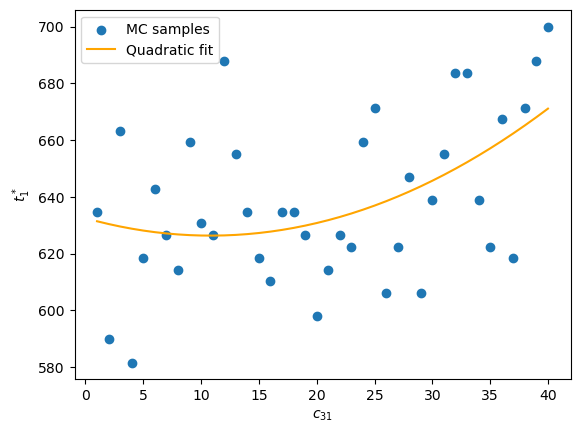

In [24]:
# plot of the optimal t1 as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['t1'])
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['t1'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('$t_1^*$')
plt.legend(['MC samples', 'Quadratic fit'])

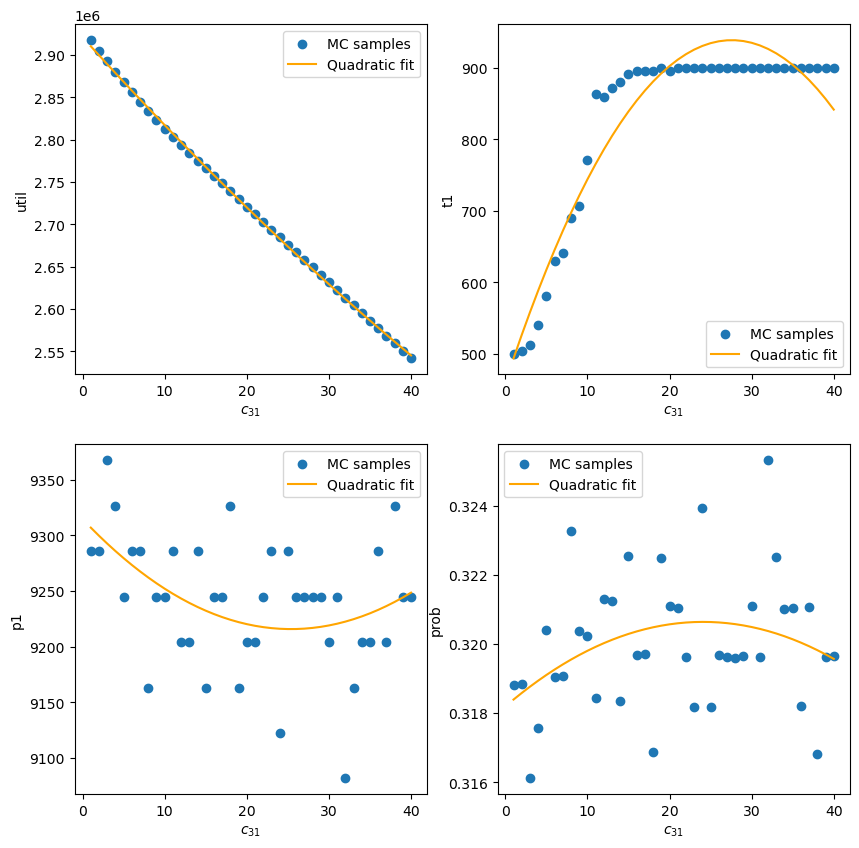

In [23]:
# do 4 subplots for util, t1, c1 and prob in a same figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for var in ['util', 't1', 'p1', 'prob']:
    ax = axs.flatten()[['util', 't1', 'p1', 'prob'].index(var)]
    ax.scatter(df_resultados['c31'], df_resultados[var])
    c, b, a = np.polyfit(df_resultados['c31'], df_resultados[var], 2)
    var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
    ax.plot(df_resultados['c31'], var_fit, color='orange')
    ax.set_xlabel('$c_{31}$')
    ax.set_ylabel(var)
    ax.legend(['MC samples', 'Quadratic fit'])

In [43]:
from skopt import gp_minimize
from skopt.space import Real
from functools import partial

# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]
    
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T):
    p1, t1 = params
    return -compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

Optimal p1: 10000.974521723736
Optimal t1: 684.1395310992547
Optimal utility: 3439618.2939981422


In [48]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

def generate_neighbor(t1, p1):
    # Generate a neighboring solution by perturbing t1 and p1 within a certain range
    new_t1 = np.clip(t1 + np.random.uniform(-50, 50), 0, 2000)
    new_p1 = np.clip(p1 + np.random.uniform(-200, 200), 3000, 15000)
    return new_t1, new_p1

def simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T, max_iter=1000):
    # Set initial temperature and cooling rate
    temperature = 1000
    cooling_rate = 0.99

    # Initialize current solution
    current_t1, current_p1 = initial_t1, initial_p1
    current_util = compute_expected_utility_vec_random_ac(current_t1, current_p1, c11, c21, c31, n, T, ite=500000)[0]

    # Initialize best solution
    best_t1, best_p1 = current_t1, current_p1
    best_util = current_util

    # Simulated Annealing algorithm
    for _ in tqdm.tqdm(range(max_iter)):
        # Generate a neighboring solution
        new_t1, new_p1 = generate_neighbor(current_t1, current_p1)

        # Calculate the cost of the new solution
        new_util = compute_expected_utility_vec_random_ac(new_t1, new_p1, c11, c21, c31, n, T, ite=500000)[0]

        # Calculate the acceptance probability
        delta_util = new_util - current_util
        acceptance_probability = np.exp(delta_util / temperature)

        # Accept or reject the new solution
        if np.random.uniform() < acceptance_probability:
            current_t1, current_p1 = new_t1, new_p1
            current_util = new_util

        # Update the best solution
        if current_util > best_util:
            best_t1, best_p1 = current_t1, current_p1
            best_util = current_util

        # Cool down the temperature
        temperature *= cooling_rate

    return best_t1, best_p1

# Example usage
initial_t1 = np.random.uniform(0, 2000)
initial_p1 = np.random.uniform(3000, 15000)
best_t1, best_p1 = simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T)
print("Best t_1:", best_t1)
print("Best p_1:", best_p1)

  1%|          | 7/1000 [00:03<07:32,  2.20it/s]/tmp/ipykernel_2725557/1674446480.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
 89%|████████▉ | 891/1000 [06:46<00:49,  2.19it/s]/tmp/ipykernel_2725557/4192258394.py:36: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp(delta_util / temperature)
100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]

Best t_1: 733.2468450183264
Best p_1: 9839.168881683318


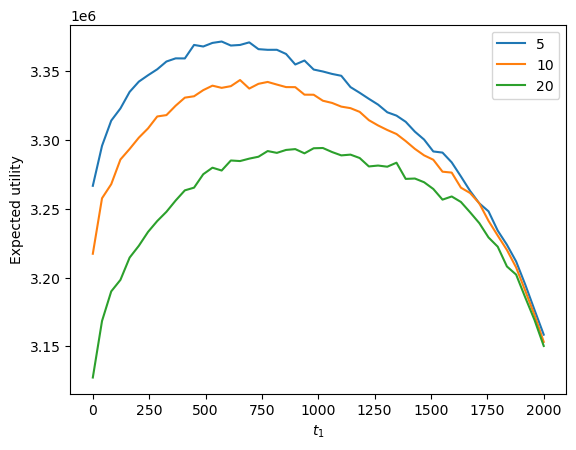

In [35]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 10151.51515152
f = 50
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=1000000, fact=f))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, 10, n, T, ite=1000000, fact=f))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, 20, n, T, ite=1000000, fact=f))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([5, 10, 20])

In [ ]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# Example usage
t1 = 606.06060606
p1 = 10151.51515152   
random_ac = []
for i in range(10):
    util, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print('Brute force: ', p1, t1, np.array(random_ac).mean())


t1 = 684.1395310992547
p1 = 10000.974521723736
random_ac = []
for i in range(10):
    util, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print('Bayesian optimization: ', p1, t1, np.array(random_ac).mean())


t1 = 733.2468450183264
p1 = 9839.168881683318
random_ac = []
for i in range(10):
    util, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print('Simulated annealing: ', p1, t1, np.array(random_ac).mean())

Brute force:  10151.51515152 606.06060606 3419547.932550885
Bayesian optimization:  10000.974521723736 684.1395310992547 3414823.2585751927
Simulated annealing:  9839.168881683318 733.2468450183264 3413118.9763172427


# Purchase of multiple items

In [25]:
def knapsack_solver(utilities, prices, budgets):
    # Generar todos los subconjuntos posibles una vez
    subsets = [[0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]]

    # Inicializar la cantidad total de ventas
    total_sells = 0

    # Precalcular las sumas de precios y utilidades para cada subconjunto
    prices_sums = np.array([prices[subset, :].sum(axis=0) for subset in subsets])
    utilities_sums = np.array([utilities[subset, :].sum(axis=0) for subset in subsets])

    # Iterar sobre cada presupuesto
    for budget in budgets:
        mask = prices_sums <= budget
        utilities_masked = np.where(mask, utilities_sums, -1000)
        indices = np.argmax(utilities_masked, axis=0)

        # Contar las ventas de productos cuyos índices son pares
        total_sells += (indices % 2 == 0).sum()

    return total_sells

In [26]:
def compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=12000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT))
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT))

    # Estimating the cost
    c1 = fact * (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Solving the knapsack problem for each buyer
    budgets = np.random.uniform(10000, 20000, (n, ite))

    total_sales = knapsack_solver(
            np.array([u1, u2, u3]), 
            np.array([p1*np.ones([ps.shape[0]]), ps[:, 0], ps[:, 1]]),
            np.array(budgets))

    # Expected utility
    s = total_sales / ite
    util = utility_func(s * p1 - c1, rho1)
    
    profit = s * p1 - c1
    
    return util, profit

In [27]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

p1 = 9000.51515152
t1 = 606.06060606

compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=1000000)

(2495301.660470527, 2495301.660470527)

In [10]:
resultados  = np.zeros((10 * 10, 3))
indice = 0
for p1 in np.linspace(3000, 15000, 10):
    for t1 in np.linspace(0, 2000, 10):
        util, _ = compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=100000)
        resultados[indice] = [p1, t1, util]
        indice += 1

71363017
74089510
74819148
75650052
75313884
75265347
74902630
74586164
73399324
70821038
62860014
64631812
64518760
64242527
63955504
63311945
63143730
62835213
62110036
60078822
53100533
53543989
53427478
52698177
51359471
51087668
50729586
50682929
50891951
49587950
43854652
43834100
42601624
41511411
40333176
39823002
39498802
39878890
40448895
39091343
35209713
34735955
32975535
31690720
30477806
29613610
29595458
30092866
30628639
30332190
28068918
27154706
25285841
23274012
22034961
21544773
21190511
22263148
22712336
22862209
20618636
19320197
17713189
16025979
14792052
14284806
14425514
14991381
15961076
16133550
14813616
13465887
11906188
10728869
9715816
9225629
9341501
10034561
10759224
11267765
10691445
9419746
8310532
7295241
6535498
6438516
6400337
6835292
7529498
7906363
7816591
6925292
6051467
5476943
4956817
4798830
4827653
5182652
5681252
5920633


# Inteligent competitors

In [48]:
def compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):   
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts[1:] ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * ts[0] / T - w[:, 1] * ps[0] / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[1] / T - w[:, 1] * ps[1] / 5000 - w[:, 2] * qs[:, 0] / eT))
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[2] / T - w[:, 1] * ps[2] / 5000 - w[:, 2] * qs[:, 1] / eT))

    # Computing probability of choice
    pi1 = (1 / (1 + np.exp(u2-u1) + np.exp(u3-u1))).mean()
    pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
    pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
    # Estimating the cost
    c1 = fact * (c11 * ts[0] + c21 * e1 + c31 * q1).mean()
    c2 = fact * (c11 * ts[1] + c21 * e1 + c31 * qs[:, 0]).mean()
    c3 = fact * (c11 * ts[2] + c21 * e1 + c31 * qs[:, 1]).mean()

    # Estimating expected utility
    util1 = np.sum([comb(n, l) * pi1**l * (1 - pi1)**(n - l) * utility_func(l * ps[0] - c1, rho1) for l in range(n+1)])
    util2 = np.sum([comb(n, l) * pi2**l * (1 - pi2)**(n - l) * utility_func(l * ps[1] - c2, rho1) for l in range(n+1)])
    util3 = np.sum([comb(n, l) * pi3**l * (1 - pi3)**(n - l) * utility_func(l * ps[2] - c3, rho1) for l in range(n+1)])
    
    return np.array([util1, util2, util3])

In [49]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# We begin optimizing p1 and t1 for random p2, t2, p3 and t3 and then optimize the rest and then again p1 and t1 for those values
# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]

# Define the objective function wrapper for skopt

def objective_function(params, c11, c21, c31, n, T, p2, t2, p3, t3):
    p1, t1 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p2=10000, t2=500, p3=10000, t3=500)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

# Define the parameter space
space = [Real(3000, 15000, name='p2'), Real(0, 2000, name='t2'),
         Real(3000, 15000, name='p3'), Real(0, 2000, name='t3')]

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T, p1, t1):
    p2, t2, p3, t3 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[1:].sum()

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p1=p1_optimal, t1=t1_optimal)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p2_optimal, t2_optimal, p3_optimal, t3_optimal = result.x
optimal_utility = -result.fun

print("Optimal p2:", p2_optimal)
print("Optimal t2:", t2_optimal)
print("Optimal p3:", p3_optimal)
print("Optimal t3:", t3_optimal)
print("Optimal utility:", optimal_utility)

# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T, p2, t2, p3, t3):
    p1, t1 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p2=p2_optimal, t2=t2_optimal, p3=p3_optimal, t3=t3_optimal)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)



/tmp/ipykernel_3035933/660115504.py:29: RuntimeWarning: overflow encountered in exp
  pi1 = (1 / (1 + np.exp(u2-u1) + np.exp(u3-u1))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:29: RuntimeWarning: overflow encountered in exp
  pi1 = (1 / (1 + np.exp(u2-u1) + np.exp(u3-u1))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykerne

Optimal p1: 9854.550030658043
Optimal t1: 0.0
Optimal utility: 4865940.2685016915


/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:30: RuntimeWarning: overflow encountered in exp
  pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
/tmp/ipykerne

Optimal p2: 8566.3089466186
Optimal t2: 950.1300627123768
Optimal p3: 14953.758382232985
Optimal t3: 29.242275631789166
Optimal utility: 5009443.509503564


/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:29: RuntimeWarning: overflow encountered in exp
  pi1 = (1 / (1 + np.exp(u2-u1) + np.exp(u3-u1))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykernel_3035933/660115504.py:31: RuntimeWarning: overflow encountered in exp
  pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
/tmp/ipykerne

Optimal p1: 10034.885742778632
Optimal t1: 0.0
Optimal utility: 4889057.179827449
